In [2]:
import pandas as pd
import matplotlib.pyplot as plt

aml_df = pd.read_parquet('../data/jp_morgan/sorted/transaction_metrics_final_aml_v3_cbflag.parquet')
aml_df['Time_step'] = pd.to_datetime(aml_df['Time_step'])

In [4]:
df1 = aml_df.copy()

In [8]:
def entity_summary_table(df):
    temp_df = df[['Time_step', 'Label', 'party_Id', 'Transaction_Id', 'USD_amount']].copy()

    total_records = len(temp_df)
    total_susp = len(temp_df[temp_df['Label'] == 1])
    
    temp_df['Time_step'] = pd.to_datetime(temp_df['Time_step'])
    temp_df['txn_date'] = pd.to_datetime(temp_df['Time_step'].dt.date)
    temp_df = temp_df.groupby('party_Id').agg(
        Time_step=('txn_date', 'min'),
        label_0_count=('Label', lambda x: (x == 0).sum()),
        label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
        label_1_count=('Label', lambda x: (x == 1).sum()),
        label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
        total_count=('Label', 'count'),
        total_volume=('USD_amount', 'sum')
    ).reset_index()
    temp_df['yr_mn'] = temp_df['Time_step'].dt.to_period('M')

    summary_df = temp_df.groupby('yr_mn').agg(
        label_0_count=('label_0_count', 'sum'),
        label_0_amount=('label_0_amount', 'sum'),
        label_1_count=('label_1_count', 'sum'),
        label_1_amount=('label_1_amount', 'sum'),
        total_count=('total_count', 'sum'),
        total_volume=('total_volume', 'sum')
    )

    # Fraud rate pct
    summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
    summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
    summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

    # Total record pct
    summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
    summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
    summary_df.index = summary_df.index.astype(str)

    return summary_df.copy()

aml_entity_summary = entity_summary_table(df1)
# fraud_entity_summary = entity_summary_table(df2)

In [10]:
df = aml_df.copy()
temp_df = df[['Time_step', 'Label', 'party_Id', 'Transaction_Id', 'USD_amount']].copy()

total_records = len(temp_df)
total_susp = len(temp_df[temp_df['Label'] == 1])

temp_df['Time_step'] = pd.to_datetime(temp_df['Time_step'])
temp_df['txn_date'] = pd.to_datetime(temp_df['Time_step'].dt.date)
temp_df = temp_df.groupby('party_Id').agg(
    Time_step=('txn_date', 'min'),
    label_0_count=('Label', lambda x: (x == 0).sum()),
    label_0_amount=('USD_amount', lambda x: x[temp_df['Label'] == 0].sum()),
    label_1_count=('Label', lambda x: (x == 1).sum()),
    label_1_amount=('USD_amount', lambda x: x[temp_df['Label'] == 1].sum()),
    total_count=('Label', 'count'),
    total_volume=('USD_amount', 'sum')
).reset_index()
temp_df['5_day_period'] = temp_df['Time_step'].dt.floor('5D')

summary_df = temp_df.groupby('5_day_period').agg(
    label_0_count=('label_0_count', 'sum'),
    label_0_amount=('label_0_amount', 'sum'),
    label_1_count=('label_1_count', 'sum'),
    label_1_amount=('label_1_amount', 'sum'),
    total_count=('total_count', 'sum'),
    total_volume=('total_volume', 'sum')
)

# Fraud rate pct
summary_df['label_1_pct'] = summary_df['label_1_count'] / (summary_df['label_1_count'] + summary_df['label_0_count'])
summary_df['label_1_rep_pct'] = summary_df['label_1_count'] / total_susp
summary_df['label_1_cumpct'] = summary_df['label_1_rep_pct'].cumsum() * 100

# Total record pct
summary_df['record_pct'] = (summary_df['label_1_count'] + summary_df['label_0_count']) / total_records
summary_df['cum_record_pct'] = summary_df['record_pct'].cumsum() * 100
summary_df.index = summary_df.index.astype(str)

In [ ]:
aml_entity_summary['']

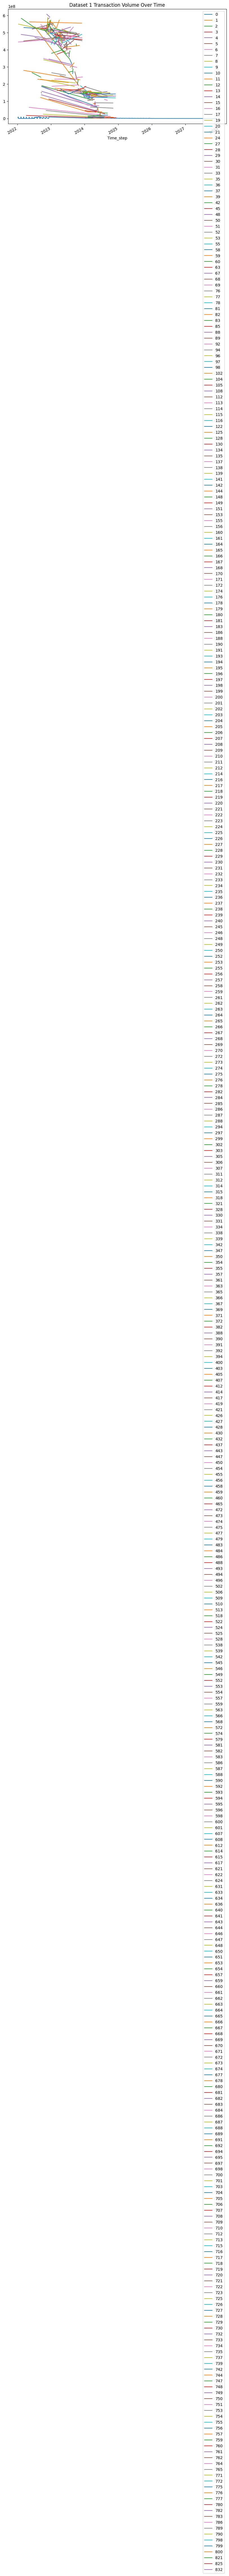

KeyboardInterrupt: 

In [2]:

def visualize_dataset(df, dataset_name):
    # Line plot of transaction volume over time by label
    plt.figure(figsize=(10,6))
    for label, data in df.resample('D', on='Time_step').sum().groupby('Label'):
        data.groupby('Time_step')['USD_amount'].sum().plot(label=label)
    plt.title(f'{dataset_name} Transaction Volume Over Time') 
    plt.legend()
    plt.show()

    # Bar chart of transaction type proportions
    plt.figure(figsize=(10,6))
    df.groupby(['Time_step', 'Transaction_Type']).size().unstack().T.plot(kind='bar', stacked=True) 
    plt.title(f'{dataset_name} Transaction Type Proportions')
    plt.show()

    # Heatmap of hour vs day patterns
    heatmap_df = df.pivot_table(index=df['Time_step'].dt.hour,
                                columns=df['Time_step'].dt.weekday, 
                                values='USD_amount', aggfunc='sum')
    
    plt.figure(figsize=(10,8))
    plt.imshow(heatmap_df, cmap='coolwarm', aspect='auto')
    plt.title(f'{dataset_name} Transaction Patterns by Hour and Day') 
    plt.show()

# Assuming df1, df2, df3 are the DataFrames for each dataset 
visualize_dataset(aml_df, 'Dataset 1')
# visualize_dataset(df2, 'Dataset 2') 
# visualize_dataset(df3, 'Dataset 3')